LDA topic model for content in each category

source: https://developer.ibm.com/tutorials/awb-lda-topic-modeling-text-analysis-python/

In [1]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models as gensimvisualize
from collections import defaultdict, Counter

In [2]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if len(word) > 2]
    return tokens

LDA model for all documents

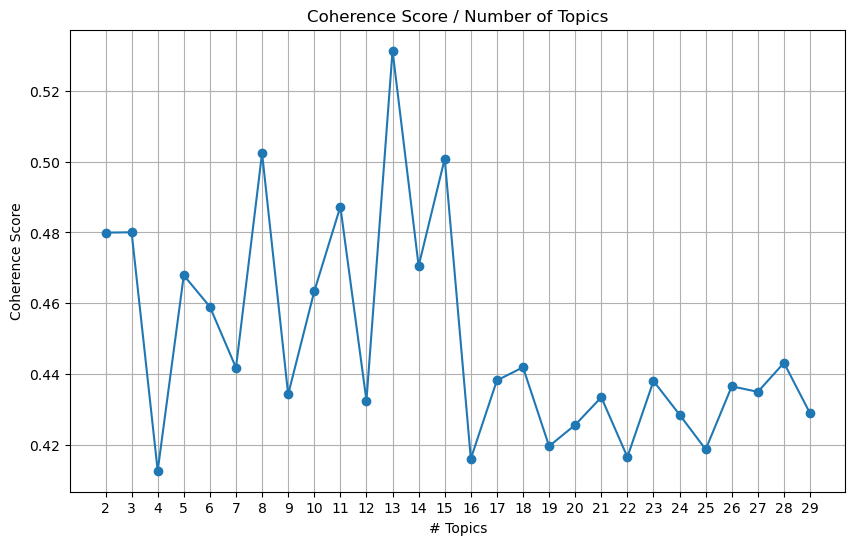

In [12]:
# Find best num of topics for highest coherence score
data = pd.read_csv('dataset/category_with_document.csv')

# Preprocess documents
data['processed_Document'] = data['Document'].apply(preprocess_text)
texts = data['processed_Document'].tolist()

# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=2)
corpus = [dictionary.doc2bow(text) for text in texts]

num_topics_list = range(2, 30)
coherence_scores = []

for num_topics in num_topics_list:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, random_state=4583,
                         chunksize=20, num_topics=num_topics, passes=50, iterations=100)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title('Coherence Score / Number of Topics')
plt.xlabel('# Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)
plt.grid()
plt.show()


In [33]:
# LDA modeling for all documents
data = pd.read_csv('dataset/category_with_document.csv')

data['processed_Document'] = data['Document'].apply(preprocess_text)
texts = data['processed_Document'].tolist()

# load dictionary
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below = 2, no_above=0.7)

# generate corpus as BoW
corpus = [dictionary.doc2bow(text) for text in texts]

# train LDA model
num_topics=11
lda_model = LdaModel(corpus=corpus, id2word=dictionary, chunksize=20, num_topics=num_topics, passes=100, iterations=200)

for topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(topic)

coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print('Coherence Score:', coherence_score)

(0, '0.190*"policy" + 0.050*"update" + 0.048*"send" + 0.033*"software" + 0.029*"help" + 0.024*"exploit" + 0.024*"discovered" + 0.023*"submit" + 0.022*"thanks" + 0.019*"youve"')
(1, '0.001*"pywps" + 0.001*"owslib" + 0.001*"pycsw" + 0.001*"autogluon" + 0.001*"codechecker" + 0.001*"auvipygmailcom" + 0.001*"idpy" + 0.001*"securelyusingpytorchsecurely" + 0.001*"psirt" + 0.001*"codecovs"')
(2, '0.059*"release" + 0.029*"fix" + 0.029*"may" + 0.025*"maintainer" + 0.022*"repository" + 0.021*"user" + 0.018*"patch" + 0.017*"time" + 0.017*"address" + 0.016*"within"')
(3, '0.067*"spark" + 0.037*"tdtd" + 0.034*"group" + 0.029*"authentication" + 0.028*"license" + 0.025*"effort" + 0.023*"however" + 0.022*"tdnonetd" + 0.022*"maintained" + 0.019*"basis"')
(4, '0.047*"cluster" + 0.031*"standalone" + 0.030*"cloud" + 0.030*"job" + 0.025*"delegation" + 0.025*"kerberos" + 0.019*"visible" + 0.018*"tdstandalone" + 0.018*"uitd" + 0.017*"keytab"')
(5, '0.052*"issue" + 0.046*"bug" + 0.040*"whitecheckmark" + 0.038*

λ = 0; the terms are ranked purely by their probability within the topic

λ = 1; the terms are ranked purely by their overall term frequency across all topics (most common terms in the dataset)

In [34]:
# visualize
dickens_visual = gensimvisualize.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(dickens_visual)

In [35]:
# Top 10 most relevance terms in each topics
topic_info = dickens_visual.topic_info
topic_terms = topic_info.groupby('Category')

category_term_counts = {topic: Counter() for topic in topic_terms.groups}
category_term_details = {topic: {} for topic in topic_terms.groups}

for topic, group in topic_terms:
    print(f"Topic {topic}:")
    sorted_words = group.sort_values(by='Freq', ascending=False)
    top_words = sorted_words[['Term', 'Freq']].head(10)
    for word, freq in zip(top_words['Term'], top_words['Freq']):
        print(f"  {word} ({freq:.2f})")
    print("\n")

top_terms_per_topic = {}

for topic, group in topic_terms:
    sorted_words = group.sort_values(by='Freq', ascending=False)
    top_terms = sorted_words[['Term', 'Freq']].head(10)  # Select top 10 terms
    top_terms_per_topic[topic] = set(top_terms['Term'])

Topic Default:
  vulnerability (658.00)
  issue (518.00)
  report (460.00)
  please (381.00)
  version (353.00)
  reporting (277.00)
  supported (245.00)
  policy (236.00)
  release (181.00)
  email (161.00)


Topic Topic1:
  vulnerability (657.67)
  report (459.26)
  issue (417.35)
  please (381.20)
  reporting (276.93)
  email (160.66)
  information (134.32)
  project (134.31)
  public (128.87)
  disclosure (98.49)


Topic Topic10:
  cluster (11.23)
  standalone (7.29)
  cloud (7.23)
  job (7.09)
  delegation (5.98)
  kerberos (5.93)
  visible (4.48)
  tdstandalone (4.28)
  uitd (4.28)
  keytab (4.02)


Topic Topic11:
  pywps (0.04)
  owslib (0.04)
  pycsw (0.04)
  autogluon (0.04)
  codechecker (0.04)
  auvipygmailcom (0.04)
  idpy (0.04)
  securelyusingpytorchsecurely (0.04)
  psirt (0.04)
  codecovs (0.04)


Topic Topic2:
  release (180.21)
  fix (89.24)
  may (89.04)
  maintainer (77.35)
  repository (67.63)
  user (62.87)
  patch (54.77)
  time (52.81)
  address (51.55)
  within

In [36]:
# Count terms occurance in each category
data = pd.read_csv('dataset/category_with_document.csv')
data['processed_Document'] = data['Document'].apply(preprocess_text)

topic_terms = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)
top_terms_per_topic = {topic: [term for term, _ in words] for topic, words in topic_terms}

# count term occurrences in each category
category_term_counts = defaultdict(Counter)
category_term_details = defaultdict(lambda: defaultdict(Counter))

# Identify terms that appear in multiple topics
term_topic_mapping = defaultdict(set)
for topic, terms in top_terms_per_topic.items():
    for term in terms:
        term_topic_mapping[term].add(topic)
multi_topic_terms = {term: topics for term, topics in term_topic_mapping.items() if len(topics) > 1}

print("Multi-topic terms:")
for term, topics in multi_topic_terms.items():
    print(f"{term}: Topics {sorted(topics)}")

multi_topic_term_category_counts = defaultdict(lambda: defaultdict(int))

# Count occurrences of multi-topic terms per category
for term, topics in multi_topic_terms.items():
    for _, row in data.iterrows():
        category = row['Category']
        document_content = str(row['processed_Document']).lower()
        count = document_content.count(term)

        if count > 0:
            multi_topic_term_category_counts[term][category] += count

# Count occurrences only for non-multi-topic terms
for topic, top_terms in top_terms_per_topic.items():
    single_topic = [term for term in top_terms if term not in multi_topic_terms]
    for _, row in data.iterrows():
        category = row['Category']
        document_content = str(row['processed_Document']).lower()

        term_counts = {term: document_content.count(term) for term in single_topic}
        total_count = sum(term_counts.values())

        category_term_counts[topic][category] += total_count

        if category not in category_term_details[topic]:
            category_term_details[topic][category] = Counter()
        category_term_details[topic][category].update(term_counts)


multi_topic_term_df = pd.DataFrame(multi_topic_term_category_counts).T.fillna(0)
multi_topic_term_df['Topics'] = multi_topic_term_df.index.map(lambda term: sorted(multi_topic_terms[term]))

# most occurrences for each topic
topic_category_analysis = {
    topic: {
        "Category": category_counts.most_common(1)[0][0] if category_counts else "None",
        "Occurrences": category_counts.most_common(1)[0][1] if category_counts else 0,
        "Terms": category_term_details[topic][category_counts.most_common(1)[0][0]] if category_counts else {}
    }
    for topic, category_counts in category_term_counts.items()
}

print(multi_topic_terms)
display(multi_topic_term_df)
display(topic_category_analysis)

Multi-topic terms:
issue: Topics [5, 9]
{'issue': {9, 5}}


,Reporting mechanism,Projects practise,Scope of practise,User guideline,Information on maintainer,Additional information,History of vulnerability,Generic policy,Topics
issue,413,33,13,45,1,26,5,35,"[5, 9]"


{0: {'Category': 'Reporting mechanism',
  'Occurrences': 291,
  'Terms': Counter({'policy': 46,
           'update': 13,
           'send': 52,
           'software': 13,
           'help': 35,
           'exploit': 36,
           'discovered': 26,
           'submit': 45,
           'thanks': 5,
           'youve': 20})},
 1: {'Category': 'Reporting mechanism',
  'Occurrences': 11,
  'Terms': Counter({'pywps': 0,
           'owslib': 0,
           'pycsw': 1,
           'autogluon': 2,
           'codechecker': 2,
           'auvipygmailcom': 2,
           'idpy': 1,
           'securelyusingpytorchsecurely': 1,
           'psirt': 2,
           'codecovs': 0})},
 2: {'Category': 'Reporting mechanism',
  'Occurrences': 464,
  'Terms': Counter({'release': 58,
           'fix': 102,
           'may': 47,
           'maintainer': 57,
           'repository': 42,
           'user': 21,
           'patch': 26,
           'time': 49,
           'address': 31,
           'within': 31})},
 3:

In [37]:
# number of term's occurance in each category content to csv
csv_data = []

# Iterate through each topic and its term count per category
for topic, category_counts in category_term_details.items():
    for category, term_counts in category_counts.items():
        for term, count in term_counts.items():
            csv_data.append({
                "Topic": topic,
                "Category": category,
                "Term": term,
                "Occurrences": count
            })


csv_df = pd.DataFrame(csv_data)
csv_filename = "topic_term_occurrences_in_cat.csv"
csv_df.to_csv(csv_filename, index=False)